<a href="https://colab.research.google.com/github/oroobyaseen/coursera.exercises/blob/gh-pages/multiclass_brain-%20tumor_classification_in_cnn_91_95_acc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!zip -r /kaggle/working/file.zip ../input/best-models

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D, Input
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, roc_curve, auc
import itertools
from itertools import cycle
from sklearn import metrics
from scipy import interp
import os
import shutil
from keras import backend as K
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
img_width, img_height = 224, 224

train_data_dir = '/content/drive/MyDrive/New folder (4)/train'
#validation_data_dir = '../input/main-dataset/main_dataset/validation'
test_data_dir = '/content/drive/MyDrive/New folder (4)/val'
nb_train_samples = 2456
nb_validation_samples = 616
epochs = 30
batch_size = 32
#regularizer = tf.keras.regularizers.l2(0.01,)

if K.image_data_format() == 'channels_first':
  input_shape = (3, img_width, img_height)
else:
  input_shape = (img_width, img_height, 3)

In [5]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.3,
    zoom_range = 0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [6]:
train_batches = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    #classes=['EOISINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL'],
    class_mode = 'categorical')

Found 2456 images belonging to 3 classes.


In [ ]:
#valid_batches = test_datagen.flow_from_directory(
   # validation_data_dir,
   # target_size = (img_width, img_height),
    #batch_size = batch_size,
    #color_mode = 'grayscale',
    #class_mode = 'categorical')

In [7]:
test_batches = test_datagen.flow_from_directory(
    test_data_dir,
    target_size = (img_width, img_height),
    batch_size = 2487,
    #color_mode = 'grayscale',
    class_mode = 'categorical')

Found 616 images belonging to 3 classes.


In [ ]:
#train_batches = ImageDataGenerator().flow_from_directory(directory=train_data_dir, target_size=(120,160), classes=['EOISINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL'], batch_size=batch_size)
#valid_batches = ImageDataGenerator().flow_from_directory(directory=validation_data_dir, target_size=(120,160), classes=['EOISINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL'], batch_size=batch_size)
#test_batches = ImageDataGenerator().flow_from_directory(directory=test_data_dir, target_size=(120,160), classes=['EOISINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL'], batch_size=600, shuffle=False)

In [8]:
def plots(ims, figsize=(12,6), rows=None, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows +1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [9]:
imgs, labels = next(train_batches)

In [ ]:
#Eoisinophil=8[1.0.0.0],Lymphocyte=4[0.1.0.0],monocyte=2[0.0.1.0],neutrophil=1[0.0.0.1]-->Labels
#plots(imgs, rows=4, titles=labels)

In [10]:
model = Sequential()
model.add(BatchNormalization(input_shape=input_shape))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

In [11]:
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [12]:
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [13]:
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [14]:
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [15]:
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
#model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))

In [16]:
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
#model.add(Dense(32))
#model.add(Activation('relu'))

model.add(Dense(3))
model.add(Activation('softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 224, 224, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 activation (Activation)     (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      9

In [ ]:
#model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
%%time
h = model.fit_generator(
    train_batches,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    validation_data = test_batches,
    validation_steps = nb_validation_samples // batch_size,
    #callbacks=[
     #   tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4),
      #  tf.keras.callbacks.ModelCheckpoint(filepath = '/kaggle/working/model_{val_accuracy:.3f}.h5', save_best_only=True,
       #                                   save_weights_only=False, monitor='val_accuracy')
    #]
    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/30
76/76 [==============================] - 165s 2s/step - loss: 0.7906 - accuracy: 0.6634
Epoch 2/30
76/76 [==============================] - 163s 2s/step - loss: 0.7240 - accuracy: 0.6927
Epoch 3/30
76/76 [==============================] - 163s 2s/step - loss: 0.6593 - accuracy: 0.7269
Epoch 4/30
76/76 [==============================] - 161s 2s/step - loss: 0.6310 - accuracy: 0.7331
Epoch 5/30
76/76 [==============================] - 156s 2s/step - loss: 0.5826 - accuracy: 0.7636
Epoch 6/30
76/76 [==============================] - 156s 2s/step - loss: 0.5459 - accuracy: 0.7880
Epoch 7/30
76/76 [==============================] - 158s 2s/step - loss: 0.5200 - accuracy: 0.7805
Epoch 8/30
76/76 [==============================] - 156s 2s/step - loss: 0.5096 - accuracy: 0.7979
Epoch 9/30
76/76 [==============================] - 155s 2s/step - loss: 0.4608 - accuracy: 0.8218
Epoch 10/30
76/76 [==============================] - 155s 2s/step - loss: 0.4436 - accuracy: 0.8280
Epoch 11/

In [19]:
test_imgs, test_labels = next(test_batches)
#plots(test_imgs, rows=10, titles=test_labels)

In [20]:
rounded_labels = np.argmax(test_labels, axis=-1)

In [26]:
from tensorflow.keras.models import load_model

model.save('model_cc.h5')

In [27]:
test_model = load_model('/content/model_cc.h5')

In [28]:
predictions = test_model.predict_generator(test_batches, steps=1, verbose=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [29]:
predictions

array([[9.8981595e-01, 4.1911757e-05, 1.0142115e-02],
       [8.0408514e-02, 9.1595000e-01, 3.6414240e-03],
       [9.5335579e-01, 1.4088073e-02, 3.2556217e-02],
       ...,
       [8.4556548e-09, 1.0000000e+00, 1.0015958e-15],
       [7.4057840e-02, 9.2593563e-01, 6.4789670e-06],
       [9.8474705e-01, 4.4965656e-03, 1.0756457e-02]], dtype=float32)

In [30]:
rounded_prediction = np.argmax(predictions, axis=-1)

In [31]:
for i in rounded_prediction:
    print(i)

0
1
0
1
0
1
2
2
0
1
1
0
1
1
2
2
1
0
2
2
2
0
2
2
2
0
0
2
0
2
1
0
2
2
2
0
0
2
2
0
0
1
0
0
1
0
0
0
2
1
0
1
2
0
0
0
2
0
1
1
2
0
0
0
1
2
1
2
2
1
0
0
1
0
0
0
0
0
2
2
2
0
1
0
1
0
0
0
0
2
1
2
2
0
0
0
2
0
2
0
0
0
0
1
2
1
0
2
2
0
0
2
2
0
0
0
0
0
0
0
2
0
0
0
0
0
1
0
1
0
0
0
0
0
2
1
0
0
2
0
1
1
0
1
0
1
2
0
1
0
2
2
1
0
2
2
0
0
0
0
2
0
2
0
1
1
0
2
0
2
0
0
2
0
2
1
0
1
2
1
0
2
0
2
2
2
2
0
1
0
2
1
2
2
2
1
0
0
0
0
0
1
0
2
0
0
0
1
0
0
0
0
0
1
1
2
0
0
2
2
2
2
2
0
2
2
0
0
1
1
2
1
2
0
0
1
1
2
0
2
0
0
0
0
2
0
0
2
2
0
2
2
0
2
0
0
0
2
2
0
0
0
2
2
2
2
0
0
2
1
2
0
0
0
1
1
0
1
0
2
1
0
0
0
2
0
2
0
1
1
0
0
0
2
2
0
2
1
0
0
1
0
2
0
1
1
0
0
0
1
0
0
1
2
0
0
2
2
0
2
0
0
0
0
0
2
0
0
0
0
1
0
2
2
0
2
0
2
1
0
0
0
2
0
1
0
0
0
1
0
0
1
0
2
1
0
0
2
0
2
0
2
0
0
2
0
0
0
2
2
2
0
0
1
0
1
1
1
1
0
1
1
2
1
2
2
2
2
2
0
1
2
2
2
0
0
0
2
2
2
0
1
2
0
2
0
2
0
2
2
0
2
2
0
0
0
0
2
2
2
2
0
2
0
2
2
0
0
2
2
0
0
2
0
2
0
0
0
1
2
0
0
0
2
2
0
0
2
0
0
2
2
0
0
0
0
2
0
0
2
0
2
0
2
0
0
0
0
2
2
0
1
0
2
1
1
2
0
2
0
2
2
0
2
0
2
0
0
0
1
0
0
0
0
0
0
0
1
0
0


In [32]:
cm = confusion_matrix(y_true=rounded_labels, y_pred=rounded_prediction)

In [46]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [47]:
print(classification_report(y_true=rounded_labels, y_pred=rounded_prediction))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       286
           1       0.95      0.76      0.84       142
           2       0.93      0.94      0.93       188

    accuracy                           0.91       616
   macro avg       0.92      0.89      0.90       616
weighted avg       0.92      0.91      0.91       616



In [33]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[279   3   4]
 [ 24 108  10]
 [  9   3 176]]


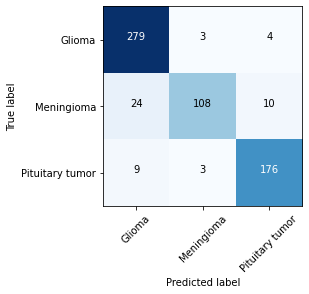

In [35]:
cm_plot_labels = ['Glioma','Meningioma', 'Pituitary tumor']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='')

In [ ]:
#test_accuracy--> 2287/2487 = 0.9195 or 91.95%

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


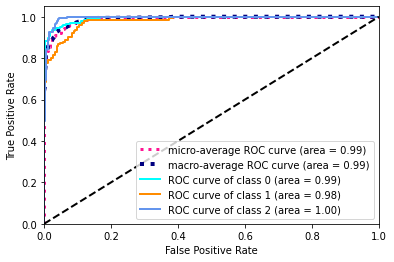

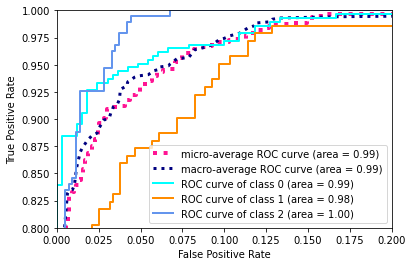

In [44]:
# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(3)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(3):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 3

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=3)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=3)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()



In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_true=rounded_labels, y_pred=rounded_prediction))

              precision    recall  f1-score   support

           0       0.90      0.85      0.87       623
           1       0.98      1.00      0.99       620
           2       0.98      0.94      0.96       620
           3       0.83      0.89      0.86       624

    accuracy                           0.92      2487
   macro avg       0.92      0.92      0.92      2487
weighted avg       0.92      0.92      0.92      2487



In [ ]:
score = metrics.log_loss(test_labels,predictions)
print("Log loss score: {}".format(score))

Log loss score: 0.2251245001956247


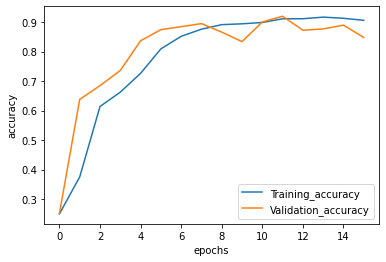

In [ ]:
accs = h.history['accuracy']
val_accs = h.history['val_accuracy']

plt.plot(range(len(accs)),accs, label = 'Training_accuracy')
plt.plot(range(len(accs)),val_accs, label = 'Validation_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()

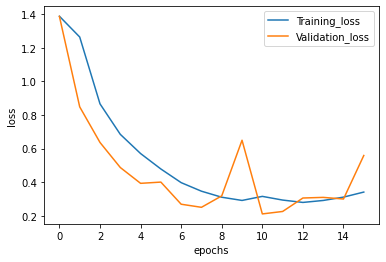

In [ ]:
accs = h.history['loss']
val_accs = h.history['val_loss']

plt.plot(range(len(accs)),accs, label = 'Training_loss')
plt.plot(range(len(accs)),val_accs, label = 'Validation_loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()